Here I test the implementation of Rotation Synthesis in the creation of the UVF_cube in py21cmwedge.

I will follow the Thompson, Morna, Swenson Ch 4 section 1:

$
\left[\begin{array}{*{5}c}
u \\ v \\ w
\end{array}
\right]
=
\left[ \begin{array}{*{10}c}
\sin H & \cos H & 0\\
-\sin \delta \cos H & \sin \delta\sin H & \cos \delta \\
\cos\delta \cos H  & -\cos \delta \sin H & \sin \delta 
\end{array}
\right]
\left[\begin{array}{*{5}c}
X_{\lambda}\\
Y_{\lambda}\\
Z_{\lambda}
\end{array}
\right]
$

Where  $X_{\lambda}$, $Y_{\lambda}$, and $Z_{\lambda}$ are the baseline vectors in the coordinate system 
definted where X points towards the meridian, Y points East and Z points towards the North Pole. 
$H$ is the Hour angle of an observation, and $\delta$ is the right ascension of an observation.

To perform a simulated rotation synthesis, we first must invert this matrix, to get uvw coordinates into $X_{\lambda}$, $Y_{\lambda}$, and $Z_{\lambda}$ (H=0,$\delta$=Array latitude), then apply this rotation for each time integration.

In [54]:
%matplotlib notebook
import numpy as np
import pyuvdata
import py21cmwedge
from matplotlib.pyplot import *
from matplotlib.colors import SymLogNorm, LogNorm
import copy
from astropy.io import fits
filename='/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap'

In [55]:
# Load the HFSS beam simulation of a HERA dish
beam = fits.getdata(filename, 'BEAM_X')
freqs = fits.getdata(filename, 'FREQS_X')
ind = np.argmin(abs(freqs-150e6))
beam_150 = beam[:,ind]

In [97]:
# We will now create a simple simulator that creates rotation synthesis for a zenith observation
def simulate_observation(input_uvw, t_int, n_obs, ra=None, drift=True):
    omega_earth = 2 * np.pi/ (23. * 3600. + 56 *60. + 4.09)  # obnoxiously precise rotation speed of the Earth.
    hour_angles = np.arange(n_obs) * t_int * omega_earth
    delta = np.repeat(latitude, n_obs)  # this should be the latitude of the array
    if drift:
        delta_prime = np.copy(delta)
    else:
        delta_prime = np.repeat(ra, n_obs)
    zero_array = np.zeros(n_obs)
    rotation_matrix = np.array([
            [np.cos(hour_angles), -np.sin(delta)*np.sin(hour_angles), np.sin(hour_angles) * np.cos(delta)],
            [np.sin(delta_prime) * np.sin(hour_angles),
             np.sin(delta_prime) * np.sin(delta) * np.cos(hour_angles) +np.cos(delta_prime)* np.cos(delta),
             -np.sin(delta_prime) * np.cos(delta) * np.cos(hour_angles) + np.cos(delta_prime) * np.sin(delta)],
            [-np.cos(delta_prime) * np.sin(hour_angles),
             -np.sin(delta) * np.cos(delta_prime) * np.cos(hour_angles) + np.sin(delta_prime)*np.cos(delta),
             np.cos(delta_prime) * np.cos(delta) * np.cos(hour_angles) + np.sin(delta_prime) * np.sin(delta)]
            ]) 
    new_uvw_array = []
    for uvw in input_uvw.T:
        _uvw = np.einsum('jik,i', rotation_matrix, uvw)
        new_uvw_array.extend(np.transpose(_uvw, [1,0]))
    new_uvw_array = np.array(new_uvw_array)
    all_zero = np.all(new_uvw_array ==0, axis=1)
    non_zero = np.logical_not(all_zero)
    return new_uvw_array.T

In [85]:
# Create A simple array
antenna_positions = np.array([[0,14.6,29.2,0], [0,0,0,29.2], [0,0,0,0] ])  
# Definte a latitude, Longitude and Altitude of the Sample Array
# We will use the defaults for HERA:
latitude = -30.7224 * np.pi/180.
longitude = +21.4278 * np.pi/180.
altitude = 0

In [86]:
# Create our default py21cmwedge object
uvgridder = py21cmwedge.UVGridder()
uvgridder.set_antpos(antenna_positions)
uvgridder.set_freqs(150e6)
uvgridder.set_uv_delta(1)
uvgridder.set_beam(beam_150)
uvgridder.calc_all()

In [87]:
# Initialize the new object with rotation synthesis
new_gridder = py21cmwedge.UVGridder()
new_gridder.set_freqs(150e6)
new_gridder.set_uv_delta(1)
new_gridder.set_beam(beam_150)

In [111]:
# we will calculate the uvw_array for this new uv object directly using the above function
# and the uvw's from the first array.
new_uvw = simulate_observation(uvgridder.uvw_array, 10.7, 357 )
new_gridder.set_uvw_array(new_uvw)
new_gridder.calc_all()

<IPython.core.display.Javascript object>


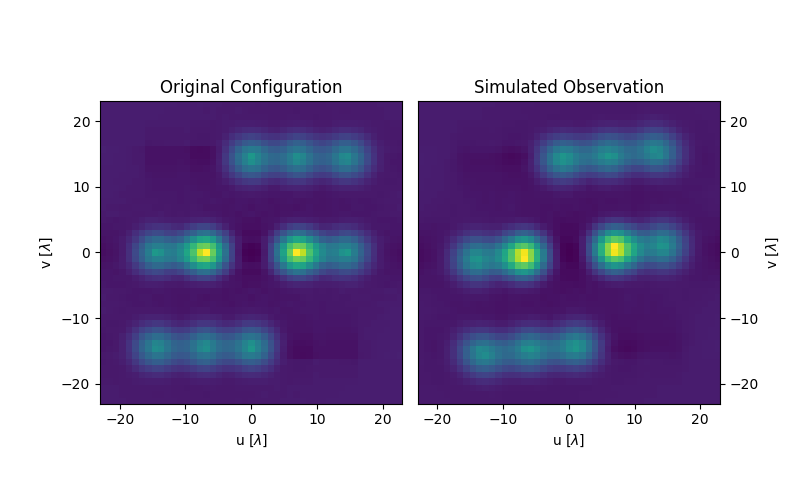

In [132]:
fig, ax = subplots(ncols=2, figsize=(8,5))
u_array = np.arange(uvgridder.uv_size) - (uvgridder.uv_size - 1)/2.
u_array*= uvgridder.uv_delta
ax[0].imshow(uvgridder.uvf_cube[0], extent=[u_array[0],u_array[-1], u_array[0], u_array[-1]])#,
#              norm=LogNorm())
ax[0].set_title('Original Configuration')
ax[0].set_xlabel('u [$\lambda$]')
ax[0].set_ylabel('v [$\lambda$]')
u_array1 = np.arange(new_gridder.uv_size) - (new_gridder.uv_size - 1)/2.
u_array1 *= new_gridder.uv_delta
ax[1].imshow(new_gridder.uvf_cube[0], extent=[u_array1[0],u_array1[-1], u_array1[0], u_array1[-1]])#,
#              norm=LogNorm())
ax[1].set_xlabel('u [$\lambda$]')
ax[1].set_ylabel('v [$\lambda$]')
ax[1].set_title('Simulated Observation')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
fig.subplots_adjust(wspace=.05)

The Field of View (Fov) of a HERA dish is about 8 degrees at 2m wavelenths.

Since the beam is squared on the sky when visibilties are created, it creates a narrowing effect.
When the DFT to the UV plane is computed, this results in a broader UV beam.

(Imagine squaring a Gaussian then computing the Fourier Transform:
you begin with a Gaussian with a given $\sigma$,
the squared beam with $\sigma ' = \frac{\sigma}{\sqrt{2}}$,
and the Fourier Transform of the square with $\sigma_{FT}= \frac{\sqrt{2}}{\sigma}$)

Therefore, we expect the gridded UV's to move by 1 beam width after integrating for twice the amount of time 
required for a source to move through the FoV. 

In this case 16 degrees, which is 1.06 hours, or 357 10.7s integrations